In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import curve_fit

# Import and process data

In [2]:
colors = {'LR':'#F57685', 'FCN':'#B51D49', 'CNN0':'#47A2F7','CNN1':'#47A2F7',
          'CNN2':'#47A2F7', 'GCN':'#6561B8', 'EnsC':'#11677E', 'EnsM':'#56AC9D'}
GB1 = 'MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDDATKTFTVTE' # WT GB1 sequence

models = ['LR','FCN','CNN0','CNN1','CNN2','GCN','EnsM','EnsC']
num_muts = [5, 10, 20, 30, 40, 50]

In [3]:
df = pd.read_csv('designs_counts.csv')

# add in model columns 
for model in models:
    mod1 = [m==model for m in df.model]
    mod2 = [(len(str(m))>4) and (model in m) for m in df.model]
    df[model] = [any((mod1[i],mod2[i])) for i in range(len(mod1))]

# df['us_0'] = df['GB1_unsorted_lib_S73_L002_210728_count']
# df['high_0'] = df['GB1_sorted_high_S77_L002_210728_count'] + df['GB1_sorted_high_S24_L002_210806_count']
# df['low_0'] = df['GB1_sorted_low_S75_L002_210728_count'] + df['GB1_sorted_low_S25_L002_210806_count']
# df['wteq_0'] = df['GB1_sorted_wtEQ_S76_L002_210728_count']
# df['disp_0'] = df['GB1_sorted_myc_S74_L002_210728_count']

# df['us_1'] = df['unsorted_lib_rep1_S107_L001_211008_count'] + df['unsorted_lib_rep1_S130_L001_211027_count']
# df['bind_1'] = df['sorted_647_rep1_S105_L001_211008_count'] + df['sorted_647_rep1_S128_L001_211027_count']
# df['disp_1'] = df['sorted_488_rep1_S103_L001_211008_count']
# df['us_2'] = df['unsorted_lib_rep2_S108_L001_211008_count']
# df['bind_2'] = df['sorted_647_rep2_S106_L001_211008_count'] + df['sorted_647_rep2_S129_L001_211027_count']
# df['disp_2'] = df['sorted_488_rep2_S104_L001_211008_count'] + df['sorted_488_rep2_S127_L001_211027_count']

df['us_0'] = df['expt2_unsorted_count']
df['high_0'] = df['expt2_bind_hi_count'] + df['expt2_bind_hi_more_reads_count']
df['low_0'] = df['expt2_bind_low_count'] + df['expt2_bind_low_more_reads_count']
df['wteq_0'] = df['expt2_bind_wt_count']
df['disp_0'] = df['expt2_display_count']

df['us_1'] = df['expt1_unsorted_rep1_count'] + df['expt1_unsorted_rep1_more_reads_count']
df['bind_1'] = df['expt1_bind_rep1_count'] + df['expt1_bind_rep1_more_reads_count']
df['disp_1'] = df['expt1_display_rep1_count']
df['us_2'] = df['expt1_unsorted_rep2_count']
df['bind_2'] = df['expt1_bind_rep2_count'] + df['expt1_bind_rep2_more_reads_count']
df['disp_2'] = df['expt1_display_rep2_count'] + df['expt1_display_rep2_more_reads_count']

df = df[[col for col in df.columns if 'count' not in col]]

# filter out sequences with less than read_cut reads in both unsorted libraries 
read_cut = 10
df = df[(df.us_1 > read_cut) & (df.us_2 > read_cut)]

# add pseudocount 
for col in df.columns:
    if col[-2:] in ['_0', '_1', '_2']:
        df[col] = df[col] + 1

# Calculate enrichments 

In [4]:
# normalize columns to get proportions 
df['us_1p'] = df['us_1']/df['us_1'].sum()
df['disp_1p'] = df['disp_1']/df['disp_1'].sum()
df['bind_1p'] = df['bind_1']/df['bind_1'].sum()
df['us_2p'] = df['us_2']/df['us_2'].sum()
df['disp_2p'] = df['disp_2']/df['disp_2'].sum()
df['bind_2p'] = df['bind_2']/df['bind_2'].sum()

In [5]:
# calc enrichments
df['high_e'] = np.log(df['high_0']) - np.log(df['us_0'])
df['low_e'] = np.log(df['low_0']) - np.log(df['us_0'])
df['wteq_e'] = np.log(df['wteq_0']) - np.log(df['us_0'])
df['disp_0e'] = np.log(df['disp_0']) - np.log(df['us_0'])

df['ebind1'] = np.log10(df['bind_1p']) - np.log10(df['disp_1p'])
df['edisp1']= np.log10(0.4*df['disp_1p'] + 0.6*df['bind_1p']) - np.log10(df['us_1p']) 

df['ebind2'] = np.log10(df['bind_2p']) - np.log10(df['disp_2p'])
df['edisp2']= np.log10(0.4*df['disp_2p'] + 0.6*df['bind_2p']) - np.log10(df['us_2p'])

# subtract WT
for var in ['high_e','low_e','wteq_e','disp_0e']:
    df[var] = df[var] - np.max(df[df.num_mut==0][var])
for var in ['ebind1','edisp1','ebind2','edisp2']:
    df[var] = df[var] - np.median(df[df.num_mut==0][var])

# Reproducibility of metrics 

0.9026987840286372


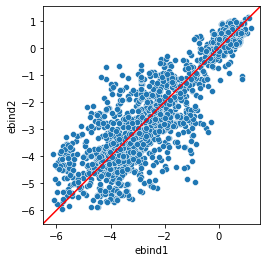

In [6]:
# fig s4a
# look at ebind reproducibility between the two replicates
sns.scatterplot(x=df['ebind1'],y=df['ebind2'])
ax = plt.gca()
ax.set_aspect('equal')
CC = np.corrcoef(df['ebind1'],df['ebind2'])[0,1]
lims = ax.get_xlim()
plt.plot(lims,lims,'r')
ax.set_xlim(lims)
ax.set_ylim(lims)
print(CC)
# plt.savefig('plots/ebind_rep_correlation.eps')

0.8356567418759119


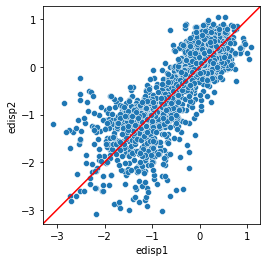

In [7]:
# fig s4a
# look at edisp reproducibility between the two replicates
sns.scatterplot(x=df['edisp1'],y=df['edisp2'])
ax = plt.gca()
ax.set_aspect('equal')
CC = np.corrcoef(df['edisp1'],df['edisp2'])[0,1]
lims = ax.get_xlim()
plt.plot(lims,lims,'r')
ax.set_xlim(lims)
ax.set_ylim(lims)
print(CC)
# plt.savefig('plots/edisp_rep_correlation.eps')

In [8]:
# add a column for calibration and wt sequences so you don't lose them when melting the dataframe.
df['Calibration'] = df.seq_id.str.contains('calibration')
df['WT'] = df.seq_id.str.contains('wt_')

Save source data for Figure S8a

In [9]:
fig_s8_src = pd.melt(df, id_vars=['seq_id', 'num_mut', 'ebind1', 'edisp1', 'ebind2', 'edisp2'], value_vars=['LR', 'FCN', 'CNN0', 'CNN1', 'CNN2', 'GCN', 'EnsM', 'EnsC', 'Calibration', 'WT'], var_name='model')
fig_s8_src = fig_s8_src[fig_s8_src.value].copy()
fig_s8_src.rename(columns={'model':'seq_origin'}, inplace=True)

# fig_s8_src.to_csv('source_data_files/fig_s8a_src.csv')

In [10]:
# average the two replicates
df['ebind'] = (df['ebind1'] + df['ebind2'])/2
df['edisp'] = (df['edisp1'] + df['edisp2'])/2

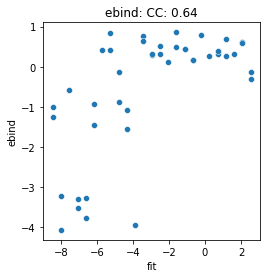

In [11]:
# fig s8c
# How does ebind correlate with original DMS fitness?
cal_seqs = pd.read_csv('calibration_seqs.csv')
cal_seqs = df.merge(cal_seqs, how='inner', left_on='seq', right_on='seq',)

sns.scatterplot(x=cal_seqs.fit,y=cal_seqs['ebind'])
CC = np.corrcoef(cal_seqs.fit,cal_seqs['ebind'])[0,1]
plt.gca().set_title('%s: CC: %0.2f' % ('ebind',CC));
plt.gca().set_box_aspect(1)
# plt.savefig('plots/ebind_DMS_correlation.eps')

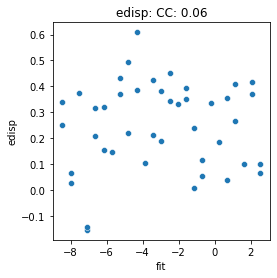

In [12]:
# fig s8c
# How does edisp correlate with original DMS fitness?
sns.scatterplot(x=cal_seqs.fit,y=cal_seqs['edisp'])
CC = np.corrcoef(cal_seqs.fit,cal_seqs['edisp'])[0,1]
plt.gca().set_title('%s: CC: %0.2f' % ('edisp',CC));
plt.gca().set_box_aspect(1)
# plt.savefig('plots/edisp_DMS_correlation.eps')

Save source data for Figure S8c

In [13]:
fig_s8c_src = cal_seqs[['seq_id', 'ebind', 'edisp']]
# fig_s8c_src.to_csv('source_data_files/fig_s8c_src.csv')

In [14]:
# Figure s8b
# get names of synonymous sequences
sel = df[df.Calibration]
fig_s8b_src = pd.DataFrame(columns=['cal_seq_id', 'ebind_a', 'ebind_b', 'edisp_a', 'edisp_b'], index=sel[sel.duplicated('seq', keep='first')].seq.tolist())

for index, row in sel[sel.duplicated('seq', keep=False)].iterrows():
    seq_version = row.seq_id[-1]
    seq_id = row.seq_id[:-1]
    fig_s8b_src.loc[row.seq, f'ebind_{seq_version}'] = row.ebind
    fig_s8b_src.loc[row.seq, f'edisp_{seq_version}'] = row.edisp
    fig_s8b_src.loc[row.seq, 'cal_seq_id'] = seq_id


ebind_cc = np.corrcoef(fig_s8b_src[['ebind_a', 'ebind_b']].T.to_numpy(dtype=float))[0,1]
edisp_cc = np.corrcoef(fig_s8b_src[['edisp_a', 'edisp_b']].T.to_numpy(dtype=float))[0,1]

print("eBind and eDsip correlation coefficients between original DMS dataset and calculated binding score:")

print(f'eBind: {ebind_cc:.2}')
print(f'eDisp: {edisp_cc:.2}')

eBind and eDsip correlation coefficients between original DMS dataset and calculated binding score:
eBind: 0.97
eDisp: 0.6


ebind: CC: 0.97, ave fold diff: 0.8
For 18 internal standard synonomous sequnences


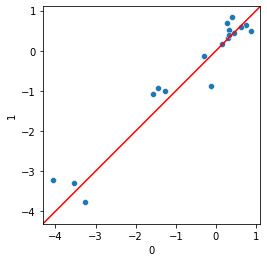

In [15]:
# fig s4c
# look at enrichment correlation between 18 synonomous internal standard sequences 

# select only double mutants 
sel = df[df.num_mut==2]
seqs = sorted(set(sel.seq))
var = 'ebind'
ax = plt.gca()

data = []
for seq in seqs:
    if len(sel[sel.seq==seq])==2:
        data.append(sel[sel.seq==seq][var].tolist())

df2 = pd.DataFrame(data)
CC = np.corrcoef(df2.T)[0,1]
MAD = np.mean(abs(df2[0] - df2[1]))
print('%s: CC: %0.2f, ave fold diff: %0.1f' % (var,CC,MAD*2.71))

sns.scatterplot(x=df2[0],y=df2[1])
ax = plt.gca()
ax.set_aspect('equal')
lims = ax.get_xlim()
plt.plot(lims,lims,'r')
ax.set_xlim(lims)
ax.set_ylim(lims)
print('For %i internal standard synonomous sequnences' % len(data))
# plt.savefig('plots/ebind_internal_correlation.eps')

edisp: CC: 0.60, ave fold diff: 0.4
For 18 internal standard synonomous sequnences


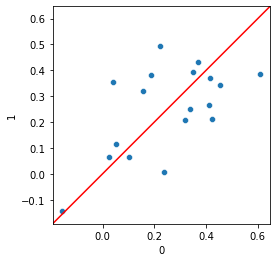

In [16]:
# fig s4c
# look at enrichment correlation between 18 synonomous internal standard sequences 

# select only double mutants 
sel = df[df.num_mut==2]
seqs = sorted(set(sel.seq))
var = 'edisp'
    
data = []
for seq in seqs:
    if len(sel[sel.seq==seq])==2:
        data.append(sel[sel.seq==seq][var].tolist())

df2 = pd.DataFrame(data)
CC = np.corrcoef(df2.T)[0,1]
MAD = np.mean(abs(df2[0] - df2[1]))
print('%s: CC: %0.2f, ave fold diff: %0.1f' % (var,CC,MAD*2.71))

sns.scatterplot(x=df2[0],y=df2[1])
ax = plt.gca()
ax.set_aspect('equal')
lims = ax.get_xlim()
plt.plot(lims,lims,'r')
ax.set_xlim(lims)
ax.set_ylim(lims)
print('For %i internal standard synonomous sequnences' % len(data))
plt.gca().set_box_aspect(1)
# plt.savefig('plots/edisp_internal_correlation.eps')

Save source data for Figure S8b.

In [17]:
# save synseqs dataframe 
# fig_s8b_src.to_csv('source_data_files/fig_s8b_src.csv')

# ebind metric

Cutoff between positive and negative: -0.50


(0.0, 255.15)

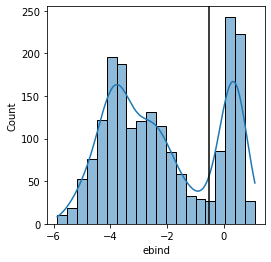

In [18]:
# fig s8d
# two Gaussian's do not give good estimate of bcutoff, so set it manually
bcutoff = -0.5

nbins = 20
sns.histplot(df['ebind'], bins = nbins, kde=True);

ylim = plt.gca().get_ylim()
print('Cutoff between positive and negative: %0.2f' % bcutoff)
plt.plot([bcutoff,bcutoff], ylim, color='k');
plt.gca().set_box_aspect(1)
plt.gca().set_ylim(ylim)
# plt.savefig('plots/ebind_hist.eps')

Save source data for Figure S8d

In [19]:
# df[['seq_id', 'ebind', 'edisp']].to_csv('source_data_files/fig_s8d_bind_src.csv')

# edisp metric

Parameters: 0.23, 0.22, 355.80, -1.11, 0.53, 115.22
Cutoff between positive and negative: -0.26


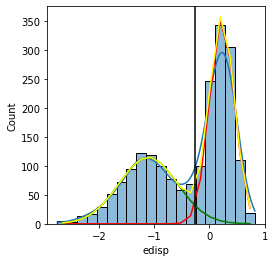

In [20]:
# fig s8d
# fit two Gaussians to histogram 
nbins = 20 # final cutoff seems to be largly independent of nbins
y,edges = np.histogram(df.edisp,nbins)
x = (edges[1:]+edges[:-1])/2 # get bin center

def gauss(x,mu,sigma,A):
    return A*np.exp(-0.5*((x-mu)/sigma)**2)

def bimodal(x,mu1,sigma1,A1,mu2,sigma2,A2):
    return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)

params,cov=curve_fit(bimodal,x,y,(0.5,1,250,-1,1,250), 
                     bounds=[(0, 0, 0, -np.inf, 0, 0), (2, np.inf, 500, 0, np.inf, 500)])

sns.histplot(df.edisp, bins = nbins, kde=True);
plt.plot(x,gauss(x,*params[:3]),color='red')
plt.plot(x,gauss(x,*params[-3:]),color='green')
plt.plot(x,bimodal(x,*params),color='yellow')

print('Parameters: '+', '.join(['%0.2f'%p for p in params]))

# determine when the positive distrbution becomes more likely 
x = np.linspace(-3,0,10000)
ylim = plt.gca().get_ylim()
dcutoff = x[np.argmax(gauss(x,*params[:3]) > gauss(x,*params[-3:]))] # Gauss1 > Gauss2
print('Cutoff between positive and negative: %0.2f' % dcutoff)
plt.plot([dcutoff,dcutoff],ylim, color='k');
plt.gca().set_ylim(ylim)
plt.gca().set_box_aspect(1)
# plt.savefig('plots/edisp_hist.eps')

Save source data for Gaussian distributions for Figure S8d

In [21]:
fig_s8d_gauss_src = pd.DataFrame(data={
    'bins':x,
    'gauss_lower':gauss(x,*params[-3:]),
    'gauss_upper':gauss(x,*params[:3]),
    'gauss_bimodal':bimodal(x,*params)
})

# fig_s8d_gauss_src.to_csv('source_data_files/fig_s8d_gaussian_src.csv')

# Look into performance of individual designs 

Save source data for Figure 3d

In [22]:
melt_df = pd.melt(df, id_vars=['seq_id', 'num_mut', 'ebind', 'edisp'], value_vars=['LR', 'FCN', 'CNN0', 'CNN1', 'CNN2', 'GCN', 'EnsM', 'EnsC'], var_name='model')
melt_df = melt_df[melt_df.value].copy()
# melt_df.to_csv('source_data_files/fig_3d_src.csv')

Fold and bind: 0.305
Fold and don't bind: 0.274
Don't fold and bind: 0.001
Don't fold and don't bind:0.419


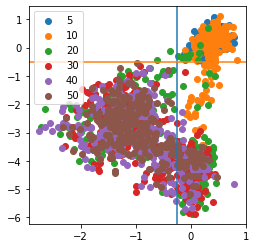

In [23]:
# fig 3d
for num_mut in num_muts:
    sel = df[df.num_mut == num_mut]
    plt.scatter(sel.edisp, sel.ebind, label=str(num_mut))
xlims = plt.gca().get_xlim()
ylims = plt.gca().get_ylim()
plt.legend()
plt.plot([dcutoff,dcutoff], ylims)
plt.plot(xlims,[bcutoff,bcutoff]);
plt.xlim(xlims)
plt.ylim(ylims)
plt.gca().set_box_aspect(1)
plt.savefig('plots/bind_display_quadrants.svg', format='svg')

# proportion in the four quadrants 
fb = np.mean((df.ebind>bcutoff) & (df.edisp>dcutoff))
fn = np.mean((df.ebind<bcutoff) & (df.edisp>dcutoff))
ub = np.mean((df.ebind>bcutoff) & (df.edisp<dcutoff))
un = np.mean((df.ebind<bcutoff) & (df.edisp<dcutoff))
print("Fold and bind: %0.3f\nFold and don't bind: %0.3f\nDon't fold and bind: %0.3f\nDon't fold and don't bind:%0.3f"%(fb,fn,ub,un))

# Look at differences in design strategies

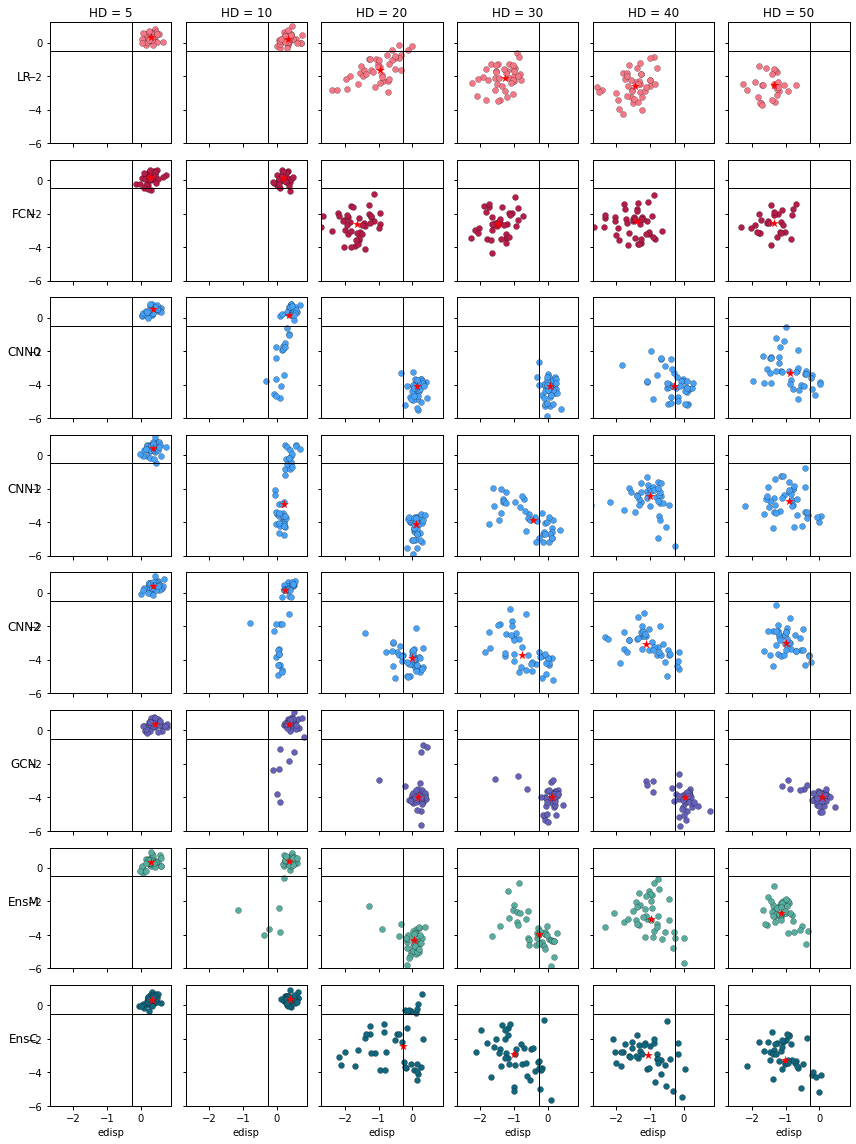

In [24]:
# fig s5

# median_df = pd.DataFrame(columns=['model', 'num_mut', 'med_ebind', 'med_edisp'])
median_df = []
fig, axes = plt.subplots(8, 6, figsize=(12,16),sharex=True, sharey=True)
for i,num_mut in enumerate(num_muts): 
    for j,model in enumerate(models):
        sel = df[(df.num_mut==num_mut) & df[model]]
        sns.scatterplot(ax=axes[j,i],x=sel.edisp,y=sel.ebind, color=colors[model], zorder=1, edgecolor='k', linewidth=0.2)
        sns.scatterplot(x=[np.median(sel.edisp)],y=[np.median(sel.ebind)],marker='*',color='r',ax=axes[j,i],zorder=2, edgecolor='r', linewidth=0.2, s=72)
        # save median data
        median_df.append({'model':model, 'num_mut':num_mut, 'med_ebind':np.median(sel.ebind), 'med_edisp':np.median(sel.edisp)})
        axes[j,i].plot([dcutoff,dcutoff],[-10,5],'k', lw=1)
        axes[j,i].plot([-5,5],[bcutoff,bcutoff],'k', lw=1)
        axes[j,i].set_xlim(-2.7,0.9)
        axes[j,i].set_ylim(-6,1.2)
        axes[j,i].xaxis.set_tick_params(width=1)
        axes[j,i].yaxis.set_tick_params(width=1)
        plt.setp(axes[j,i].spines.values(), linewidth=1)
        
# add column and row titles 
for ax, col in zip(axes[0], ['HD = %i'%n for n in num_muts]):
    ax.set_title(col)

for ax, row in zip(axes[:,0], models):
    ax.set_ylabel(row, rotation=0, size='large')

fig.tight_layout()
plt.savefig('plots/design_matrix.eps')

median_df = pd.DataFrame.from_dict(median_df)

Save source data for Figure S9. Median values used here are also used in Figure S10.

In [25]:
fig_s9_src = pd.melt(df, id_vars=['seq_id', 'num_mut', 'edisp', 'ebind'], value_vars=['LR', 'FCN', 'CNN0', 'CNN1', 'CNN2', 'GCN', 'EnsM', 'EnsC'], var_name='model')
fig_s9_src = fig_s9_src[fig_s9_src.value]

# fig_s9_src.to_csv('source_data_files/fig_s9_designs_src.csv')
# median_df.to_csv('source_data_files/fig_s9_medians_src.csv')

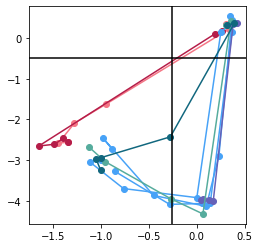

In [26]:
# fig s10

for model in models:
    mb = []
    md = []
    for num_mut in num_muts: 
        sel = df[(df.num_mut==num_mut) & df[model]]
        mb.append(np.median(sel.ebind))
        md.append(np.median(sel.edisp))
    plt.plot(md,mb,'o-',color=colors[model])

ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()
plt.plot([dcutoff,dcutoff],ylim, color='k')
plt.plot(xlim,[bcutoff,bcutoff], color='k')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
plt.gca().set_box_aspect(1)
plt.savefig('plots/design_medians.eps')

/Users/chase/miniconda3/envs/gb1_inf_v2/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 7.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


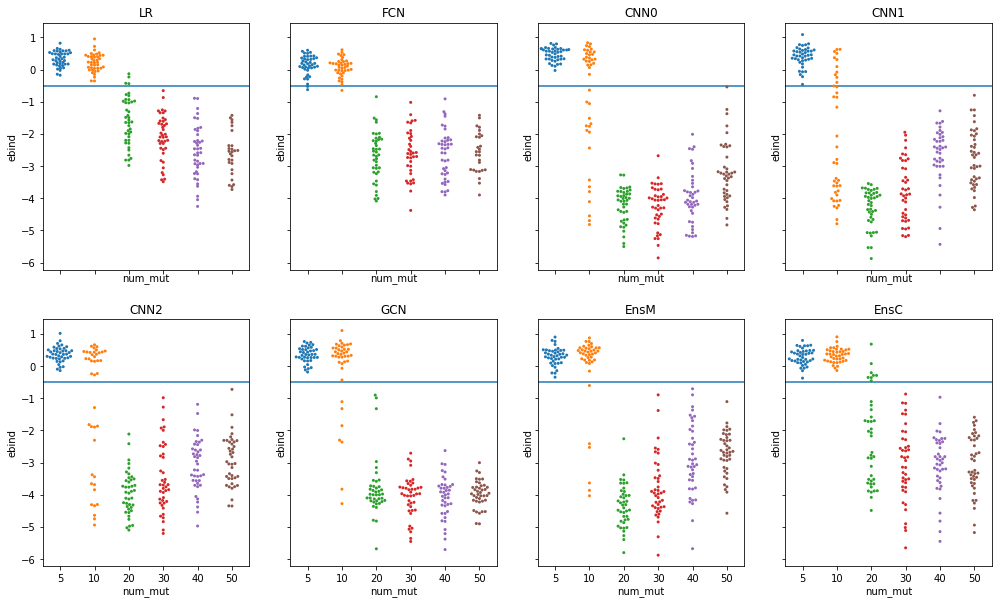

In [27]:
# fig 3c
var = 'ebind'

fig, axs = plt.subplots(2, 4, figsize=(17, 10), sharey=True, sharex=True)

swarm_dfs = []  # adding to collect source data
for m, ax in zip(models, axs.flatten()):
    swarm_dfs.append(df[(df[m])])
    sns.swarmplot(data=df[(df[m])], x='num_mut', y=var, ax=ax, size=3)
    ax.axhline(bcutoff)
    ax.set_title(m)

Save source data for Figure 3c.

In [28]:
swarm_dfs = pd.concat(swarm_dfs)
swarm_dfs_src = pd.melt(swarm_dfs, id_vars=['seq_id', 'num_mut', 'ebind', 'edisp'], value_vars=['LR', 'FCN', 'CNN0', 'CNN1', 'CNN2', 'GCN', 'EnsM', 'EnsC'], var_name='model')
swarm_dfs_src = swarm_dfs_src[swarm_dfs_src.value].copy()
# swarm_dfs_src.to_csv('source_data_files/fig_3c_src.csv')

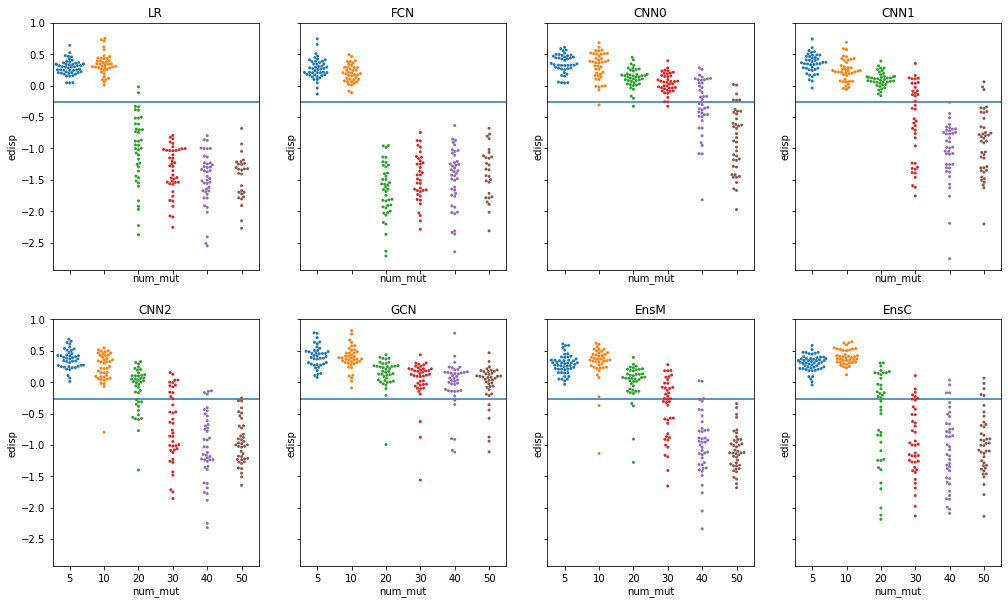

In [29]:
var = 'edisp'
fig, axs = plt.subplots(2, 4, figsize=(17, 10), sharey=True, sharex=True)

# swarm_dfs = []  # adding to collect source data
for m, ax in zip(models, axs.flatten()):
    # violin_plot_bind = [list(df[df[m] & (df.num_mut==n)][var]) for n in num_muts]
    # plt.figure()
    # swarm_dfs.append(df[(df[m])])
    sns.swarmplot(data=swarm_dfs_src[swarm_dfs_src.model == m], x='num_mut', y=var, ax=ax, size=3)
    ax.axhline(dcutoff)
    ax.set_title(m)

# Kex2 related to display

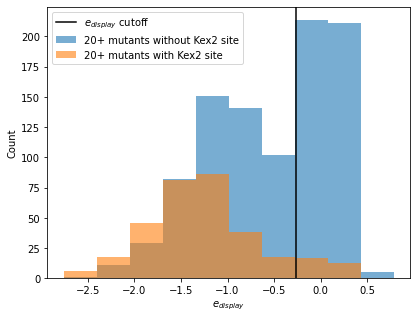

In [30]:
# fig s7
from sklearn.metrics import confusion_matrix
df['protease_site'] = df.seq.str.contains('[KR]R')
fig_s11_src = df[df.num_mut > 10][['seq_id', 'model', 'num_mut','edisp', 'protease_site']].copy()
# fig_s11_src.rename(columns={'protease_site':'kex2_site'}, inplace=True)
plt.figure(figsize=(6.5,5))

_, bins, _ = plt.hist(fig_s11_src.loc[(fig_s11_src.num_mut >= 20) & (~fig_s11_src['protease_site'])]['edisp'], alpha=.6)
plt.hist(fig_s11_src.loc[(fig_s11_src.num_mut >= 20) & (fig_s11_src['protease_site'])]['edisp'], bins=bins, alpha=.6)
ylims = plt.ylim()
plt.plot([dcutoff, dcutoff], ylims, color='k')
plt.ylim(ylims)
plt.xlabel('Edisplay')
plt.legend([r'$e_{display}$ cutoff', '20+ mutants without Kex2 site', '20+ mutants with Kex2 site'])
plt.xlabel(r'$e_{display}$')
plt.ylabel('Count')
# plt.savefig('plots/kex2_sites.png', dpi=300)
plt.show()

Save source data for Figure S11

In [31]:
# fig_s11_src.to_csv('source_data_files/fig_s11_src.csv')

Text(33.0, 0.5, 'Model')

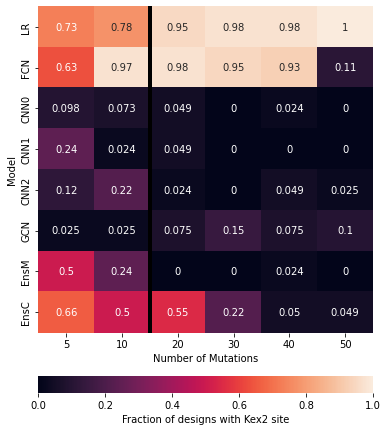

In [32]:
# fig s12
plt.figure(figsize=(6,8))

protease_counts = []
for model in models:
    protease_count = []
    for num_mut in num_muts:
        p_sites = df.loc[(df[model]) & (df['num_mut'] == num_mut)]['protease_site'] 
        protease_count.append(p_sites.mean())
    protease_counts.append(protease_count)

protease_counts_df = pd.DataFrame(protease_counts, index=models, columns=num_muts)
sns.heatmap(protease_counts_df, 
            cbar_kws={'label': 'Fraction of designs with Kex2 site', 
                      "orientation": "horizontal", 'pad':0.1}, 
            annot=True)
# plt.plot([2,2], [0,len(models)], color='k')
plt.plot([2,2], [0,len(models)], color='black', linewidth=4)
# plt.plot([2,2], [0,len(models)], color='black', linewidth=4)
plt.xlabel('Number of Mutations')
plt.ylabel('Model')
# plt.savefig('plots/model_kex2.png', dpi=300)

Save source data for Figure S12

In [33]:
# protease_counts_df.to_csv('source_data_files/fig_s12_src.csv')

# Categorical description of binding

In [34]:
df['bin'] = np.nan
df.loc[df['us_0'] > read_cut, 'bin'] = 'No function'
df.loc[((df['us_0'] > read_cut) & 
        (df['low_e'] > 1)), 'bin'] = 'Low bind'

df.loc[((df['us_0'] >= read_cut) & 
        (df['wteq_e'] > -2) & 
        (df['high_e'] <= -2)), 'bin'] = 'WT Eq bind'

df.loc[((df['us_0'] >= read_cut) & 
        (df['high_e'] > -2)), 'bin'] = 'High bind'

{'High bind': 38} {'High bind': 20, 'WT Eq bind': 15, 'Low bind': 1, 'No function': 1}


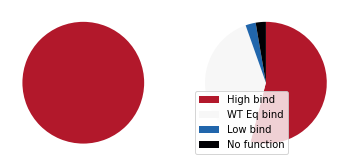

{'High bind': 33, 'WT Eq bind': 1} {'High bind': 33}


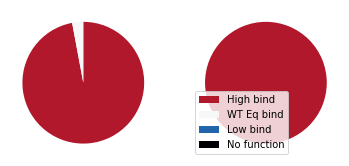

{'High bind': 27, 'Low bind': 4, 'WT Eq bind': 10} {'Low bind': 13, 'WT Eq bind': 4, 'High bind': 10, 'No function': 12}


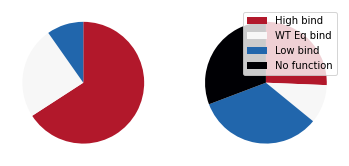

{'High bind': 19, 'Low bind': 10, 'WT Eq bind': 11, 'No function': 1} {'No function': 29, 'WT Eq bind': 2, 'Low bind': 9, 'High bind': 1}


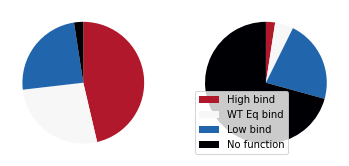

{'WT Eq bind': 6, 'High bind': 29, 'Low bind': 2} {'High bind': 9, 'WT Eq bind': 5, 'Low bind': 7, 'No function': 19}


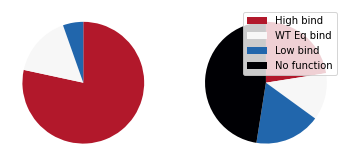

{'High bind': 23, 'Low bind': 5, 'WT Eq bind': 5} {'WT Eq bind': 10, 'No function': 5, 'Low bind': 18, 'High bind': 2}


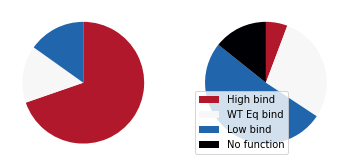

{'High bind': 34, 'Low bind': 2, 'WT Eq bind': 1} {'High bind': 21, 'No function': 6, 'WT Eq bind': 3, 'Low bind': 9}


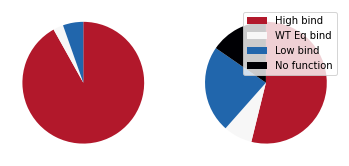

{'High bind': 37} {'High bind': 31, 'WT Eq bind': 5, 'Low bind': 1}


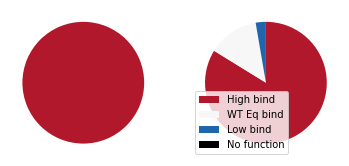

In [35]:
# fig 3e
from collections import Counter

src_df = []

plot_order = ['High bind', 'WT Eq bind', 'Low bind', 'No function']
for model in models:
    sel5 = df[(df.num_mut==5) & df[model]]
    sel10 = df[(df.num_mut==10) & df[model]]

    # drop nan - indicates designs that weren't counted due to too-few reads
    counts5 = dict(Counter(sel5.bin.dropna().tolist()))
    counts10 = dict(Counter(sel10.bin.dropna().tolist()))

    for nmut, cnts in zip([5, 10], [counts5, counts10]):
        src_dict = {'model':model, 'num_mut': nmut}
        for po in plot_order:
            if po in cnts:
                src_dict[po] = cnts[po]
        src_df.append(src_dict)

    fig, (a5, a10) = plt.subplots(1, 2)

    for c, ax in zip([counts5, counts10], [a5, a10]):
        ax.pie([c.get(cat, 0) for cat in plot_order], counterclock=False, startangle=90, 
               colors=['#b2182b', '#f7f7f7', '#2166ac', '#000004'])
        
    print(counts5, counts10)
    plt.legend(plot_order)
    plt.show()
    # plt.savefig('plots/bind_piechart_'+model+'.eps', format='eps')

src_df = pd.DataFrame.from_dict(src_df)

Save source data for Figure 3e.

In [36]:
src_df.fillna(0, inplace=True)
# src_df.to_csv('source_data_files/fig_3e_src.csv')

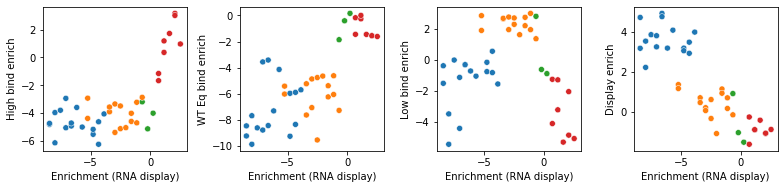

In [37]:
# fig s15
cal_seqs = pd.read_csv('calibration_seqs.csv')
cal_seqs = df.merge(cal_seqs, how='inner', left_on='seq', right_on='seq',)

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(11, 3))

for name, read_name, ax in zip(['High bind enrich', 'WT Eq bind enrich', 'Low bind enrich', 'Display enrich'], 
                           ['high_e', 'wteq_e', 'low_e', 'disp_0e'], axes):
    sns.scatterplot(data=cal_seqs, x='obs fit', y=read_name, hue='bin', ax=ax, legend=False)
    ax.set_xlabel('Enrichment (RNA display)')
    ax.set_ylabel(name)
    ax.set_box_aspect(1)
plt.tight_layout()
# plt.savefig('plots/categorical_bind_calibration.eps', format='eps')

Save source data for Figure S15

In [38]:
cal_seqs.rename(columns={
    'obs fit':'Enrichment (RNA display)',
    'high_e':'High bind enrich',
    'wteq_e':'WT Eq bind enrich',
    'low_e':'Low bind enrich',
    'disp_0e':'Display enrich',
    'bin':'Binding Activity'
},
inplace=True)

# cal_seqs[['seq_id', 'Enrichment (RNA display)', 'High bind enrich', 'WT Eq bind enrich', 'Low bind enrich', 'Display enrich', 'Binding Activity']].to_csv('../data_files/fig_s15_src.csv')

Save library sequences with enrichment scores from FACS experiments.

In [39]:
df.to_csv('new_designs_scores.csv')